# Cluster Analysis Based on MCI Original

In [231]:
'''
Import key packages
'''
import umap
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from functools import reduce
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans


# debug mode (spits messages verbosely)
DEBUG = 0  # change it to 0 to switch it off

loc="../../../WES/Clinical Data/Raw/"
outdata="../../../WES/Clinical Data/Processed/"

config =dict(\
varsnormalise=['udprs_Disease_Progression','udprs_Age_Diagnosis','cog1_MMSE result',\
'udprs_non_tremor','udprs_tremor','udprs_tremor_ratio','cog1_NART','BDI_BDI Total'],\
nonnormvars=['cog1_Trails A Z score','Lm2_cut','ESS_norm','FOGQ_FOGQ 3','DDE_norm'],\
umap_neigbours=10,umap_comps=2,kmeans_try=10)

varsnormalise=config['varsnormalise']
nonnormvars=config['nonnormvars']


varsnormalise=['udprs_Disease_Progression','udprs_Age_Diagnosis','cog1_MMSE result',\
'udprs_tremor_ratio','cog1_NART','BDI_BDI Total']
nonnormvars=['cog1_Trails A Z score','Lm2_cut','ESS_norm','FOGQ_FOGQ 3','DDE_norm']

In [232]:
def z_score(col):
    x = (col - col.mean())/col.std(ddof=0)
    return  x

def takeonlyx_sd(df,x=5):

    for var in df.columns:
        if re.search('float|int',str(df[var].dtype)):
            maxvar=df[var].mean()+df[var].std()*5
            minvar=df[var].mean()-df[var].std()*5
            mask_rng=(df[var].between(minvar,maxvar))
            df[var][~mask_rng]=df[var][mask_rng].mean()
           # print(df[var].max())
           # print(df.shape)
    return df

def replacenullsmean(df,dropcols=['SYDID','Date of assessment','max_date']):
    usecols=[col for col in df.columns if col not in dropcols]
    df[usecols]=df[usecols].replace([np.inf, -np.inf], np.nan)
    for col in df[usecols].columns:
        nullmask=(df[col].isna())
        df[col][nullmask]=df[col][~nullmask].mean()
    return df

def umap_reducer(df,vars,neighb=10,comp=5):
    df_out=df.copy()
    
    for col in df_out.columns:
        if df_out[col].dtype!='object':
            df_out[col]=df_out[col].fillna(df_out[col][pd.notnull(df_out[col])].mean())
              
    dmod=df_out[[col for col in vars if col!='SYDID' and re.search('float',str(df_out[col].dtype))
                and df_out[col].count()>=df_out.shape[0]]]
    print(dmod.shape)
    
    reducer= umap.UMAP(n_neighbors=neighb,n_components=comp)
    reddata = pd.DataFrame(reducer.fit_transform(dmod)).reset_index()
    df_out=df_out.reset_index()
    print(reddata.shape)
    
    reddata.columns=['index','umap_var1','umap_var2']
    print(reddata)
    df_out[['umap_var1','umap_var2']]=reddata[['umap_var1','umap_var2']]
    return df_out

def tsne_reducer(df,vars,comp=5):
    df_out=df.copy()
    
    for col in df_out.columns:
        if df_out[col].dtype!='object':
            df_out[col]=df_out[col].fillna(df_out[col][pd.notnull(df_out[col])].mean())
              
    dmod=df_out[[col for col in vars if col!='SYDID' and re.search('float',str(df_out[col].dtype))
                and df_out[col].count()>=df_out.shape[0]]]
    print(dmod.shape)
    
    dod_embedded = pd.DataFrame(TSNE(n_components=2).fit_transform(dmod)).reset_index()

    print(dod_embedded.shape)
    df_out=df_out.reset_index()
    
    dod_embedded.columns=['index','tsne_var1','tsne_var2']
    df_out[['index','tsne_var1','tsne_var2']]=dod_embedded[['index','tsne_var1','tsne_var2']]
    return df_out



def elbow_clust(df,clustrange=10,clustfit=4,dropvars=['SYDID','Date of assessment','max_date']):
    df_vars=df.drop(columns=dropvars)
    dv2=[col for col in df_vars if df_vars[col].dtype=='float32']
    print(dv2)
    df_vars=df_vars[dv2]
    print(df_vars.columns)
    df_vars=replacenullsmean(df_vars)
    
    wcss=[]
    #print(df_vars.head())
    for i in range(1,clustrange): 
         kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=clustrange-1,random_state=0)
         kmeans.fit(df_vars)
         wcss.append(kmeans.inertia_)
    plt.plot(range(1,clustrange),wcss)
    plt.title('The Elbow Method Graph')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    kmeans = KMeans(n_clusters=clustfit, random_state=0).fit(df_vars)
    df['cluster_label']=kmeans.labels_.tolist()
    return df

def findcols(df,string):
    return [col for col in df.columns if re.search(string,col)]

In [233]:
PDcombined=pd.read_csv('%s%s' % (outdata,'PDcombined.csv'))

In [235]:
findcols(PDcombined,'DBS')

[]

In [210]:
longvars=['udprs_SectionIIITotal_coef','cog1_MMSEresult_coef','udprs_UDPRS_Tot_coef']

#### Data Processing

In [211]:
mask_BDI_miss=(PDcombined['BDI_BDI Total']>200)

In [212]:
PDcombined=PDcombined[~(mask_BDI_miss)]

In [213]:

logmem2cutoff=PDcombined['cog1_Logical Memory II'].mean()+PDcombined['cog1_Logical Memory II'].std()*1.5
masklm2=(PDcombined['cog1_Logical Memory II']<logmem2cutoff)

PDcombined['Lm2_cut']=0
PDcombined['Lm2_cut'][(masklm2)]=1

mask0=(PDcombined['udprs_DDE']>0)
masklt1000=(PDcombined['udprs_DDE']<1000)
PDcombined['DDE_norm']=0
PDcombined['DDE_norm'][mask0&masklt1000]=1
PDcombined['DDE_norm'][mask0&~masklt1000]=2

maskbdi=(PDcombined['BDI_BDI Total']>13)
PDcombined['BDI_norm']=0
PDcombined['BDI_norm'][maskbdi]=1

maskess=(PDcombined['ESS_ESS Total']>10)
PDcombined['ESS_norm']=0
PDcombined['ESS_norm'][maskess]=1

mask_ratio=((PDcombined['udprs_tremor_ratio']==np.inf))
PDcombined['udprs_tremor_ratio'][mask_ratio]=PDcombined['udprs_tremor_ratio'][~mask_ratio].mean()

for col in varsnormalise:
    nullmask=(PDcombined[col].isna())
    PDcombined[col][nullmask]=PDcombined[col][~nullmask].mean()
    PDcombined[col+'_z_score']=z_score(PDcombined[col])
vars_z=[var +'_z_score' for var in varsnormalise ]
varscluster=np.append(['SYDID','Date of assessment'],nonnormvars)
varscluster=np.append(varscluster,vars_z)

'''
Substitute to only have max date
'''
PDcombined['max_date']=PDcombined.groupby('SYDID')['Date of assessment'].transform(max)

mask_date_max=(PDcombined['max_date']==PDcombined['Date of assessment'])
PDcombined_sub=PDcombined[mask_date_max]

'''
Removal of columns that don't work
'''

othcols=[col for col in PDcombined.columns if (PDcombined[col].dtype!='object'\
and col not in varscluster) or col in ['SYDID','Date of assessment','udprs_Disease_Progression',\
'udprs_Age_Diagnosis']]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path(

In [214]:
PDcluster_alt=PDcombined_sub[othcols]
PDcluster=PDcombined_sub[varscluster]

for var in PDcluster.columns:
    PDcluster=PDcluster[(PDcluster[var]!=999)]
    
PDcluster_alt=takeonlyx_sd(df=PDcluster_alt,x=3)
PDcluster_alt=replacenullsmean(PDcluster_alt)

'''
Reduce using umap
'''

pdclust_umap=umap_reducer(PDcluster_alt,PDcluster_alt.columns,\
neighb=config['umap_neigbours'],comp=config['umap_comps'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/pand

(151, 344)
(151, 3)
     index  umap_var1  umap_var2
0        0  -0.795945   4.036835
1        1   1.189013   5.380008
2        2  -2.308353   4.507133
3        3  -2.211964   4.489297
4        4   5.421565 -17.245352
..     ...        ...        ...
146    146  -0.431330  -2.825418
147    147   1.009566  -4.816080
148    148   0.072164   4.405061
149    149   1.080852  -4.831202
150    150  -0.292878  -3.073512

[151 rows x 3 columns]


In [224]:

mask=(pd.notnull(PDcluster_clust['SYDID'])&pd.notnull(PDcluster_clust['Date of assessment']))
mask2=(pd.notnull(PDcombined['SYDID'])&pd.notnull(PDcombined['Date of assessment']))

PDcombined_new=PDcombined[varsused][mask2&mask1]

In [225]:
PDcombined_new.shape

(151, 11)

In [229]:
def cluster_output(df=PDcluster,reps=10):
    
    df_new=pd.DataFrame([]) 
    df_out=takeonlyx_sd(df,x=3)
    df_out=replacenullsmean(df_out)
    
    for i in range(reps):
    
        pdclust_umap=umap_reducer(df_out,varscluster,\
        neighb=2,comp=config['umap_comps'])

        PDcluster_clust=elbow_clust(pdclust_umap[['SYDID','Date of assessment','umap_var1','umap_var2']],\
        clustfit=3,dropvars=['SYDID','Date of assessment'])
        
        df1=PDcluster_clust[['SYDID','cluster_label']]
        df1['rep']=i
        
        clust=pd.merge(df1,PDcombined_new,on=['SYDID'],how='inner')
        print(clust.shape)

        
        df_new=pd.concat([df_new,df1],axis=0)
        
    return df_new
        
        
        



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 34 separate connected components using meta-embedding (experimental)
  n_components


(150, 8)
(150, 3)
     index  umap_var1  umap_var2
0        0  -1.194963  13.725238
1        1   5.417904  13.514036
2        2  -5.933767 -12.687480
3        3 -17.714569   6.278927
4        4   3.531425   7.488156
..     ...        ...        ...
145    145  -8.733317   1.403721
146    146  -0.765288  13.997039
147    147  -1.173580  13.774188
148    148  -7.626539   9.237736
149    149  10.459366  16.530764

[150 rows x 3 columns]
['umap_var1', 'umap_var2']
Index(['umap_var1', 'umap_var2'], dtype='object')


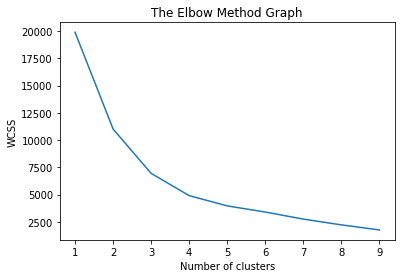

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 34 separate connected components using meta-embedding (experimental)
  n_components


(150, 13)
(150, 8)
(150, 3)
     index  umap_var1  umap_var2
0        0  -2.969751  11.443625
1        1  12.203068   6.933165
2        2   6.472773   0.679295
3        3  -7.998545  -6.227688
4        4  -3.399644   4.984309
..     ...        ...        ...
145    145  -0.808024  -8.466299
146    146  -3.743254  11.818148
147    147  -3.080467  11.528769
148    148 -13.447178  10.925482
149    149  -2.713913   7.137551

[150 rows x 3 columns]
['umap_var1', 'umap_var2']
Index(['umap_var1', 'umap_var2'], dtype='object')


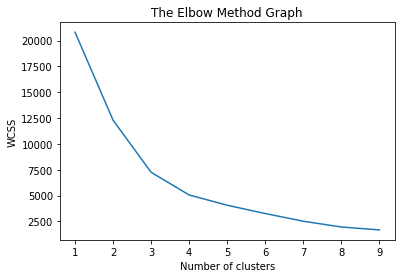

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 34 separate connected components using meta-embedding (experimental)
  n_components


(150, 13)
(150, 8)
(150, 3)
     index  umap_var1  umap_var2
0        0  -6.793925   6.087516
1        1   3.718125   9.129786
2        2   3.788895 -11.307458
3        3 -11.579409 -14.129869
4        4   9.229444   5.953177
..     ...        ...        ...
145    145  -7.302522  -5.448761
146    146  -7.130891   5.696496
147    147  -6.902075   6.132998
148    148   1.794894  -3.181888
149    149   4.969357  13.298967

[150 rows x 3 columns]
['umap_var1', 'umap_var2']
Index(['umap_var1', 'umap_var2'], dtype='object')


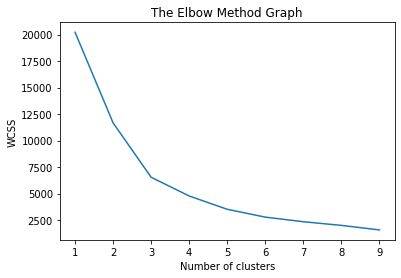

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 34 separate connected components using meta-embedding (experimental)
  n_components


(150, 13)
(150, 8)
(150, 3)
     index  umap_var1  umap_var2
0        0   5.015749   6.516695
1        1   2.134093   3.258002
2        2  -0.273063  -9.712245
3        3 -15.951084   7.983637
4        4  11.237322  -0.632647
..     ...        ...        ...
145    145  -5.108874 -11.734145
146    146   5.677897   6.338300
147    147   5.124955   6.489564
148    148   4.517876  -9.706638
149    149 -10.496844   1.279151

[150 rows x 3 columns]
['umap_var1', 'umap_var2']
Index(['umap_var1', 'umap_var2'], dtype='object')


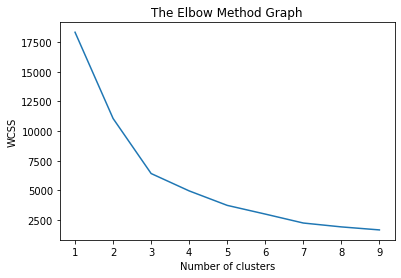

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 34 separate connected components using meta-embedding (experimental)
  n_components


(150, 13)
(150, 8)
(150, 3)
     index  umap_var1  umap_var2
0        0  -5.884735  14.413833
1        1   6.236416   2.074288
2        2   2.070129  -6.554227
3        3  -5.036587  -2.920681
4        4  -2.587730  -2.704590
..     ...        ...        ...
145    145   1.971511 -16.229549
146    146  -6.172524  14.845578
147    147  -5.932024  14.359722
148    148  -8.546223  11.896676
149    149   8.297733  13.038577

[150 rows x 3 columns]
['umap_var1', 'umap_var2']
Index(['umap_var1', 'umap_var2'], dtype='object')


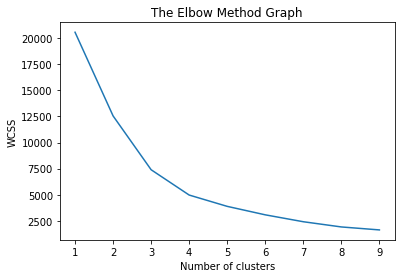

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 34 separate connected components using meta-embedding (experimental)
  n_components


(150, 13)
(150, 8)
(150, 3)
     index  umap_var1  umap_var2
0        0   2.799311  13.631018
1        1   3.029180  17.840080
2        2  -3.845919   1.824756
3        3  -4.452206   5.492384
4        4   7.185684   3.011843
..     ...        ...        ...
145    145   0.343928 -10.704992
146    146   2.514337  12.836186
147    147   2.815521  13.540563
148    148 -10.264430  -2.093285
149    149   3.693081   4.227244

[150 rows x 3 columns]
['umap_var1', 'umap_var2']
Index(['umap_var1', 'umap_var2'], dtype='object')


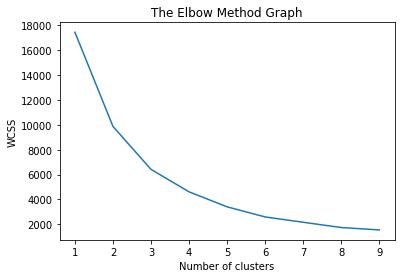

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 34 separate connected components using meta-embedding (experimental)
  n_components


(150, 13)
(150, 8)
(150, 3)
     index  umap_var1  umap_var2
0        0  -2.016051  16.211256
1        1   4.361472   4.052159
2        2  -0.950218 -11.924273
3        3 -14.370608   2.394262
4        4   2.323900   8.923383
..     ...        ...        ...
145    145 -12.901086  -2.856596
146    146  -2.366457  16.584497
147    147  -2.034984  16.248634
148    148   0.544860  -3.201017
149    149  -1.347338  12.943872

[150 rows x 3 columns]
['umap_var1', 'umap_var2']
Index(['umap_var1', 'umap_var2'], dtype='object')


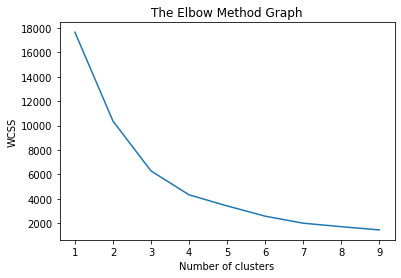

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 34 separate connected components using meta-embedding (experimental)
  n_components


(150, 13)
(150, 8)
(150, 3)
     index  umap_var1  umap_var2
0        0  -9.083644   7.519300
1        1  17.262764  -0.382732
2        2  -7.047533  -9.737647
3        3  -9.724417   2.891275
4        4  -0.579307  12.409409
..     ...        ...        ...
145    145   0.766137   0.720680
146    146  -8.308291   7.801814
147    147  -8.972729   7.489272
148    148 -10.276405   0.895915
149    149  13.501225  12.580672

[150 rows x 3 columns]
['umap_var1', 'umap_var2']
Index(['umap_var1', 'umap_var2'], dtype='object')


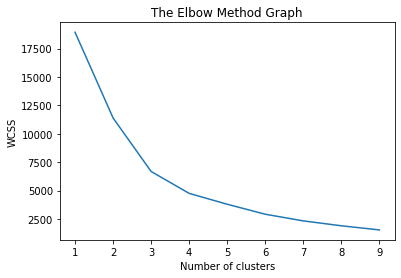

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 34 separate connected components using meta-embedding (experimental)
  n_components


(150, 13)
(150, 8)
(150, 3)
     index  umap_var1  umap_var2
0        0   1.186760  -0.482670
1        1   6.015699   9.206833
2        2   6.341625  -8.686722
3        3  -7.238320  -3.326977
4        4   5.300811  -0.131504
..     ...        ...        ...
145    145   0.197246 -10.983126
146    146   0.365392  -0.105792
147    147   1.159681  -0.478253
148    148 -15.342777   2.207847
149    149   0.469768  18.014765

[150 rows x 3 columns]
['umap_var1', 'umap_var2']
Index(['umap_var1', 'umap_var2'], dtype='object')


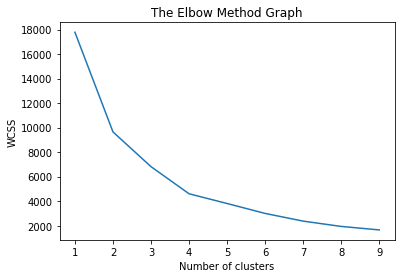

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 34 separate connected components using meta-embedding (experimental)
  n_components


(150, 13)
(150, 8)
(150, 3)
     index  umap_var1  umap_var2
0        0  -5.105640  14.067780
1        1  12.198353  10.878497
2        2  -3.223700 -13.944235
3        3  -2.160891  -0.458298
4        4  12.124585   0.397780
..     ...        ...        ...
145    145  -5.422166 -13.149732
146    146  -4.608286  14.676888
147    147  -5.060050  14.109423
148    148  -4.425866   7.139349
149    149   4.175494   4.971677

[150 rows x 3 columns]
['umap_var1', 'umap_var2']
Index(['umap_var1', 'umap_var2'], dtype='object')


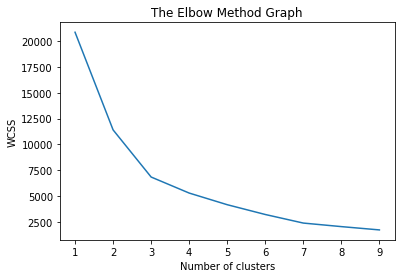

(150, 13)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [230]:
all_clust=cluster_output()

In [228]:
all_clust

,SYDID,cluster_label,rep
0,PD_00001_DA,2,0
1,PD_00002_MW,2,0
2,PD_00004_AW,1,0
3,PD_00008_BM,1,0
4,PD_00017_RE,0,0
...,...,...,...
145,PD_00553_KM,1,9
146,PD_00555_PH,0,9
147,PD_00557_DC,0,9
148,PD_00568_MB,0,9


In [220]:
all_clust.groupby(['SYDID','cluster_label']).size()

SYDID        cluster_label
PD_00001_DA  0                2
             1                5
             2                3
PD_00002_MW  0                4
             1                3
                             ..
PD_00568_MB  1                1
             2                3
PD_00583_KC  0                3
             1                3
             2                4
Length: 433, dtype: int64

,SYDID,Date of assessment,udprs_Disease_Progression,udprs_Age_Diagnosis,BDI_BDI Total,cog1_MMSE result,udprs_non_tremor,udprs_tremor,udprs_tremor_ratio,cog1_NART,DDE_norm
0,PD_00001_DA,2013-05-28,0.029580,59.764545,10.0,24.0,2.1,1.0,0.476190,89.0,2
1,PD_00002_MW,2011-10-25,0.049159,64.172485,11.0,30.0,1.9,0.2,0.105263,102.0,1
5,PD_00004_AW,2014-07-21,0.011002,55.186858,3.0,29.0,1.1,0.0,0.000000,112.0,2
7,PD_00008_BM,2014-11-03,0.021748,64.164271,9.0,30.0,1.6,2.2,1.375000,118.0,1
8,PD_00017_RE,2011-08-23,0.038875,64.796715,10.0,25.0,0.8,0.4,0.500000,121.0,1
...,...,...,...,...,...,...,...,...,...,...,...
250,PD_00553_KM,2012-10-16,0.029314,68.711841,4.0,29.0,2.3,0.2,0.086957,107.0,2
251,PD_00555_PH,2012-11-20,0.072569,70.644764,13.0,25.0,0.9,0.8,0.888889,113.0,1
252,PD_00557_DC,2012-11-06,0.017993,69.878166,4.0,26.0,1.3,0.6,0.461538,103.0,1
253,PD_00568_MB,2012-11-27,9.000000,76.673511,11.0,30.0,2.1,0.8,0.380952,115.0,0


In [193]:
#pdclust_tsne=tsne_reducer(PDcluster,varscluster,2)

In [194]:
PDcluster=takeonlyx_sd(df=PDcluster,x=3)
PDcluster=replacenullsmean(PDcluster)

pdclust_umap=umap_reducer(PDcluster,varscluster,\
neighb=2,comp=config['umap_comps'])

(150, 8)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWa

(150, 3)
     index  umap_var1  umap_var2
0        0  -0.411061   2.071773
1        1   8.349899   7.603102
2        2  -8.136537 -11.370152
3        3  -3.107959  -9.946385
4        4   6.757675   8.638041
..     ...        ...        ...
145    145   0.871761  -3.673747
146    146  -0.466330   2.603683
147    147  -0.388951   2.044470
148    148  -6.782938   8.854002
149    149   4.664352  13.575341

[150 rows x 3 columns]


In [195]:
pdclust_umap=umap_reducer(PDcluster,PDcluster.columns,neighb=10,comp=2)

(150, 8)
(150, 3)
     index  umap_var1  umap_var2
0        0   2.800707   0.949076
1        1   1.131264  -0.898016
2        2   0.061022   3.124319
3        3   2.206969   4.282503
4        4   1.986599   0.699516
..     ...        ...        ...
145    145   1.885683   1.478881
146    146   2.850404   0.159183
147    147   2.590519   0.918364
148    148   1.639149   2.886956
149    149   0.272416   1.319296

[150 rows x 3 columns]


['umap_var1', 'umap_var2']
Index(['umap_var1', 'umap_var2'], dtype='object')


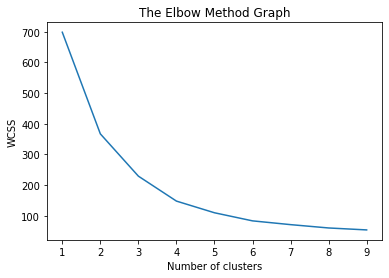

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


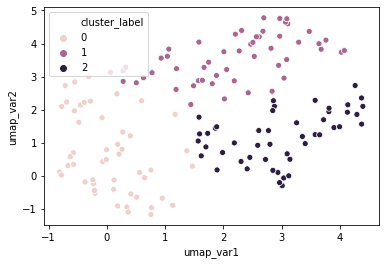

In [196]:
PDcluster_clust=elbow_clust(pdclust_umap[['SYDID','Date of assessment','umap_var1','umap_var2']],\
clustfit=3,dropvars=['SYDID','Date of assessment'])

sns.scatterplot(data=PDcluster_clust, x="umap_var1", y="umap_var2",hue='cluster_label')


In [197]:
mask1=(PDcombined['Date of assessment']==PDcombined['max_date'])

print(PDcombined.shape)
print(PDcluster_clust.shape)

varsused=['SYDID','Date of assessment','udprs_Disease_Progression','udprs_Age_Diagnosis','BDI_BDI Total','cog1_MMSE result',\
'udprs_non_tremor','udprs_tremor','udprs_tremor_ratio','cog1_NART','DDE_norm']

mask=(pd.notnull(PDcluster_clust['SYDID'])&pd.notnull(PDcluster_clust['Date of assessment']))
mask2=(pd.notnull(PDcombined['SYDID'])&pd.notnull(PDcombined['Date of assessment']))


(252, 555)
(150, 5)


In [198]:
PDcluster_clust_new=PDcluster_clust[['SYDID','Date of assessment','cluster_label']][mask]
PDcombined_new=PDcombined[varsused][mask2&mask1]

In [199]:
PDcombined_new.shape

(151, 11)

In [200]:


PDcluster_clust_new['Date of assessment']=pd.to_datetime(PDcluster_clust_new['Date of assessment'])
PDcombined_new['Date of assessment']=pd.to_datetime(PDcombined_new['Date of assessment'])

print(PDcluster_clust_new.shape)
print(PDcombined_new.shape)

clust=pd.merge(PDcombined_new,PDcluster_clust_new,on=['SYDID','Date of assessment'],how='inner')
print(clust.shape)

(150, 3)
(151, 11)
(150, 12)


In [201]:


print(clust.shape)

clust_gp_mean=pd.DataFrame(clust.groupby(['cluster_label'])['udprs_Disease_Progression','udprs_Age_Diagnosis','cog1_MMSE result',\
 'udprs_non_tremor','udprs_tremor','udprs_tremor_ratio','cog1_NART','BDI_BDI Total'].mean()).reset_index()

clust_gp_size=pd.DataFrame(clust.groupby(['cluster_label']).size()).reset_index()
clust_gp_size.columns=['cluster_label','num_patients']

clust_gp_mean=pd.merge(clust_gp_mean,clust_gp_size,on='cluster_label',how='inner')
clust_gp_mean

(150, 12)


,cluster_label,udprs_Disease_Progression,udprs_Age_Diagnosis,cog1_MMSE result,udprs_non_tremor,udprs_tremor,udprs_tremor_ratio,cog1_NART,BDI_BDI Total,num_patients
0,0,0.020592,53.678750,29.000000,1.473469,0.265306,0.199586,110.567918,9.918367,49
1,1,0.198995,62.524402,29.490566,1.122642,0.743396,0.721468,113.921283,6.754717,53
2,2,0.036279,62.912446,27.145833,1.300000,0.566667,0.483700,105.041667,10.187500,48


In [168]:
PDcombined['Date of assessment']=pd.to_datetime(PDcombined['Date of assessment'])

PDCombined_clust=pd.merge(PDcombined,PDcluster_clust_new,on=['SYDID','Date of assessment'],how='inner')


In [169]:
PDCombined_clust_long=pd.merge(PDcombined,PDCombined_clust[['SYDID','cluster_label','Group']],on='SYDID',how='left')

In [170]:
PDCombined_clust_long.to_csv('%s%s' % (outdata,'PDCombined_clust_long.csv'))

In [171]:
PDCombined_clust.to_csv('%s%s' % (outdata,'PDCombined_clust.csv'))

In [109]:
PDCombined_clust.groupby(['cluster_label','Group']).size()

cluster_label  Group
0              1.0      16
               2.0       5
               3.0       6
1              1.0       8
               2.0       1
               3.0       4
               4.0       2
2              1.0      10
               2.0       2
               3.0       8
               4.0       2
3              1.0      20
               2.0       7
               3.0       1
               4.0      14
dtype: int64

In [23]:
mask_gp=pd.notnull(PDCombined_clust['Group'])
PDCombined_clust[mask_gp].shape

(106, 556)